<a href="https://colab.research.google.com/github/longhowlam/python_hobby_stuff/blob/master/german_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Or, alternatively view this notebook in [jupyter notebook viewer](https://nbviewer.org/github/longhowlam/python_hobby_stuff/blob/master/german_credit.ipynb). It renders the interactive HTML plots better than the notebook rendering on GitHub.

# Introduction

This notebook shows the analysis results of the German credit data set, as part of the assessment for EE. The data set I used in this notebook is downloaded from Kaggle. See the data on Kaggle[ here](https://www.kaggle.com/btolar1/weka-german-credit?select=credit-g.csv). 

My first weapons of choice for structured (i.e. tabular) data like the german credit data set are **pandas**, **pandas-profiling**, [**plotly-express**](https://plotly.com/python/plotly-express/) and [**sweetviz**](https://github.com/fbdesignpro/sweetviz). The main modeling tool I am using here is [**pycaret**](https://pycaret.gitbook.io/docs/). It is a low code tool that is essentially a wrapper around other ML tools such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, etc. The uniform low code approach which will benefit readability and maintainability of ML code, while on the other hand the code does allow for enough flexbility to tweak models if needed. Moreover, it provides interactive explorative data analysis.

This notebook was created on google colab. It is a convenient analysis environment, it provides a free python run-time environment accessible from just a browser. Moreover, there are already a lot python packages installed. And as bonus, the interactive [data table viewer](https://colab.research.google.com/notebooks/data_table.ipynb) inside colab notebooks are very handy to browse and glance trough data.  

**Alternatively**, Download Anaconda, create a new conda environment with the neccesary packages. And use jupyter lab (locally) or Visual Studio Code as the environments to edit notebooks.

    conda create -n mypycaret python=3.8
    conda activate mypycaret 
    pip install pycaret[full] xgboost sweetviz shap

Installing pycaret will make use of scikit-learn 0.23, which will be installed, instead of the newer 0.24 version. Pycaret does not yet support scikit-learn 0.24. 



# German Credit Introduction

The german credit data set is a data set with 1000 loan applicants, each row is a loan applicant. There are twenty input variables, i.e. loan and loan-applicant characteristics and there is one binary target. The target tells us whether the loan is considerd bad or good.

This kind of **loan performance** data, where the bank has kept track of the performance of loans of past applicants, can be used to create a predictive model (a machine learning model) to score new loan applicants. That means, new loan applicants are given a score according to a machine learning model. When the score is high enough, above a certain **treshold**,  the loan is approved and otherwise rejected (or put in consideration). Now the process of making a good score and how to set the treshold is called **credit scoring** and we'll describe it here in this notebook.

# Installs and packages needed

In [ ]:
### install pycaret, shap and autoviz, other packages are already available on google colab
!pip install pycaret[full]
!pip install shap
!pip install sweetviz

Might need to upgrade numpy on colab because with the pycaret install an older version is also put in place that causes problems on colab. This is somewhat a bummer of colab. A lot of packages are there but if you need a packages that 'requires' an older version, you might run into problems sometimes.

In [ ]:
!pip install numpy --upgrade

In [ ]:
#### python packages needed
import pandas as pd
import numpy as np

from pycaret.classification import *

import plotly.express as px
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

In [ ]:
%matplotlib inline

# Data Import 

In [ ]:
german_credit = pd.read_csv('credit-g.csv')

### Create a numerical target with 1 for good and 0 for bad, that is usefull for plotting good/bad ratios.
german_credit['num_target'] =  np.where(german_credit['class'] == 'good', 1, 0)
german_credit.shape

(1000, 22)

In [ ]:
### we are goint to replace some charachters in certain category levels
### xgboost doesn't like column names with <, these will appear when doing one-hot encoding with pycaret

german_credit["checking_status"] = german_credit["checking_status"].replace( {'<': '_LT_', '=':'', '>':'_GT_' }, regex=True)
german_credit["savings_status"] = german_credit["savings_status"].replace( {'<': '_LT_', '=':'', '>':'_GT_' }, regex=True)
german_credit["employment"] = german_credit["employment"].replace( {'<': '_LT_', '=':'', '>':'_GT_' }, regex=True)

In [ ]:
###first five records of the data set
german_credit.head(5)

checking_status  duration                  credit_history  \
0           _LT_0         6  critical/other existing credit   
1   0_LT_X_LT_200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3           _LT_0        42                   existing paid   
4           _LT_0        24              delayed previously   

               purpose  credit_amount    savings_status   employment  \
0             radio/tv           1169  no known savings        _GT_7   
1             radio/tv           5951           _LT_100  1_LT_X_LT_4   
2            education           2096           _LT_100  4_LT_X_LT_7   
3  furniture/equipment           7882           _LT_100  4_LT_X_LT_7   
4              new car           4870           _LT_100  1_LT_X_LT_4   

   installment_commitment     personal_status other_parties  residence_since  \
0                       4         male single          none                4   
1                       2  female div/dep/mar          none                2   
2                       2         male single          none                3   
3                       2         male single     guarantor                4   
4                       3         male single          none                4   

  property_magnitude  age other_payment_plans   housing  existing_credits  \
0        real estate   67                none       own                 2   
1        real estate   22                none       own                 1   
2        real estate   49                none       own                 1   
3     life insurance   45                none  for free                 1   
4  no known property   53                none  for free                 2   

                  job  num_dependents own_telephone foreign_worker class  \
0             skilled               1           yes            yes  good   
1             skilled               1          none            yes   bad   
2  unskilled resident               2          none            yes  good   
3             skilled               2          none            yes  good   
4             skilled               2          none            yes   bad   

   num_target  
0           1  
1           0  
2           1  
3           1  
4           0

# Data Exploration

We are going to use **pandas profiling** to glance through visuals to get a first understanding of the data. The visuals can be displayed in the notebook, or because a lot of visuals are created, it might be more convenient to export the output to a html file from which it is easier to dive into the visuals. Either way, there is no shortcut, you should glance trough visuals.

Moreover, in real use cases, often you need to confront the business with 'strange' or counter intuitive findings. This will give you more reassurance that the data is OK or that you have tackled data issues.

## Profiling report

In [ ]:
from pandas_profiling import ProfileReport
prof = ProfileReport(german_credit, interactions=None,  title="German Credit Profiling Report")
prof.to_file(output_file='german_credit_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
### display profile report in the notebook
prof

## Target - Input profiles

By looking at the 'correlations' section of the pandas-profiling output, we already got some idea which of the input variables correlate (strongly) with the target variable. From a first glance, we see the input variables 

+ checking status, 
+ duration,
+ age and 
+ saving status. 


We are going to dive in a bit deeper here. We are not only interested in whether or not there is correlation between an input variable and the target, we want to get an understanding in the relationship between an input variable and the target.


The following plots make use of the numerical target (being **1 for good** and **0 for bad**). When using lowess smoothing (or just averages for categorical variables) we immediately get the good/bad ratio estimated for certain values of the inputs.

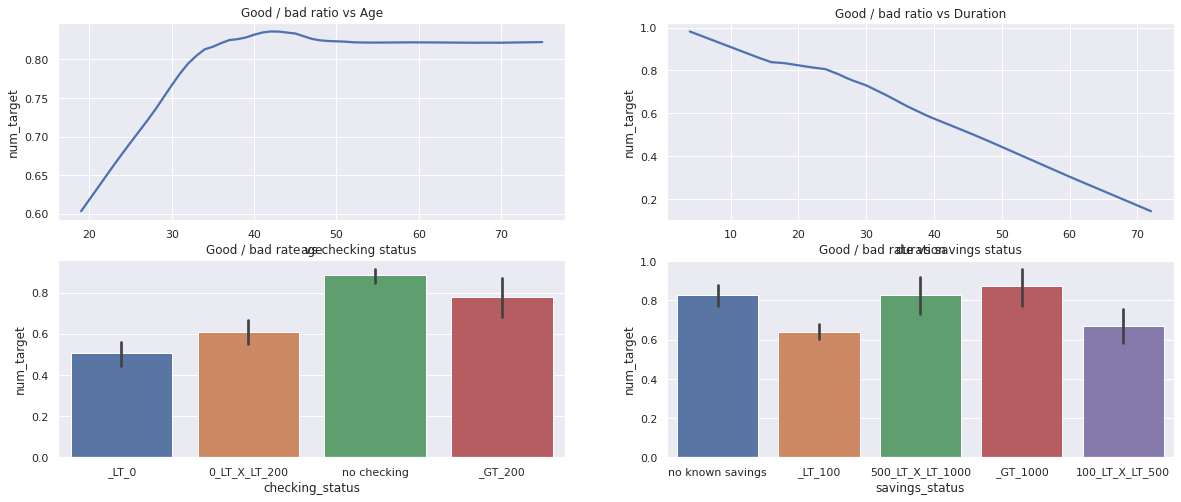

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2,  figsize=(20,8))

sns.regplot(
    x = "age", 
    y = "num_target", 
    data = german_credit, 
    lowess=True,
    scatter = False,
    ax=axs[0,0]
).set(title='Good / bad ratio vs Age')

sns.regplot(
    x = "duration", 
    y = "num_target", 
    data = german_credit, 
    lowess=True,
    scatter = False,
     ax=axs[0,1]
).set(title='Good / bad ratio vs Duration')

sns.barplot(
    x = "checking_status", 
    y = "num_target", 
    data = german_credit,
    ax=axs[1,0]
).set(title = "Good / bad rate vs checking status")

sns.barplot(
    x = "savings_status", 
    y = "num_target", 
    data = german_credit,
    ax=axs[1,1]
).set(title = "Good / bad rate vs savings status")

plt.show()

As we expected from the first correlation statistics, the above plots show clear trends in good/bad ratio and the four input variables. The older the applicants are the better the good bat ratios are.

### Sweetviz

A nice alternative to create **target - input variable profile plots** manually for all interesting input variables as I did above, is to make use of the [Sweetviz](https://github.com/fbdesignpro/sweetviz) package. It automatically profiles each input variable against the target.



In [ ]:
target_analysis = sv.analyze(german_credit, target_feat = 'num_target')

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
#### export the visual as an interactive html file for analysis outside this notebook
target_analysis.show_html("sweetviz_germancredit.html")

Report sweetviz_germancredit.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



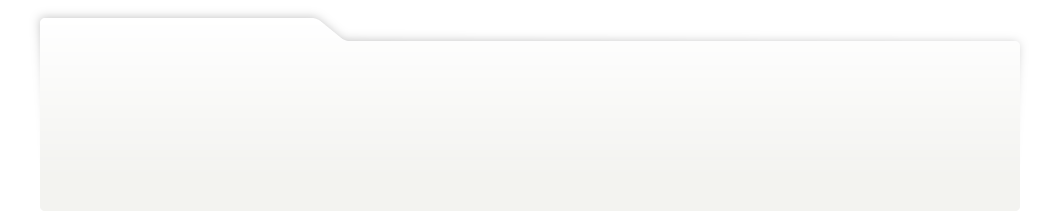
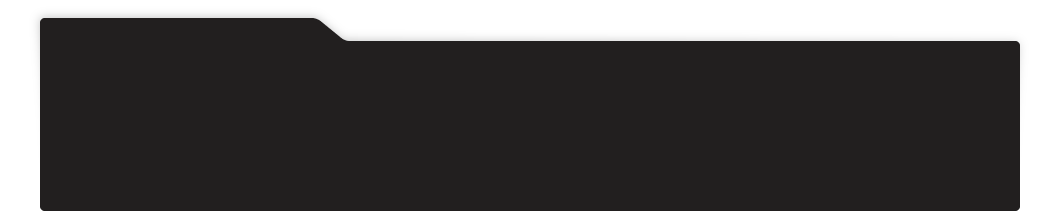
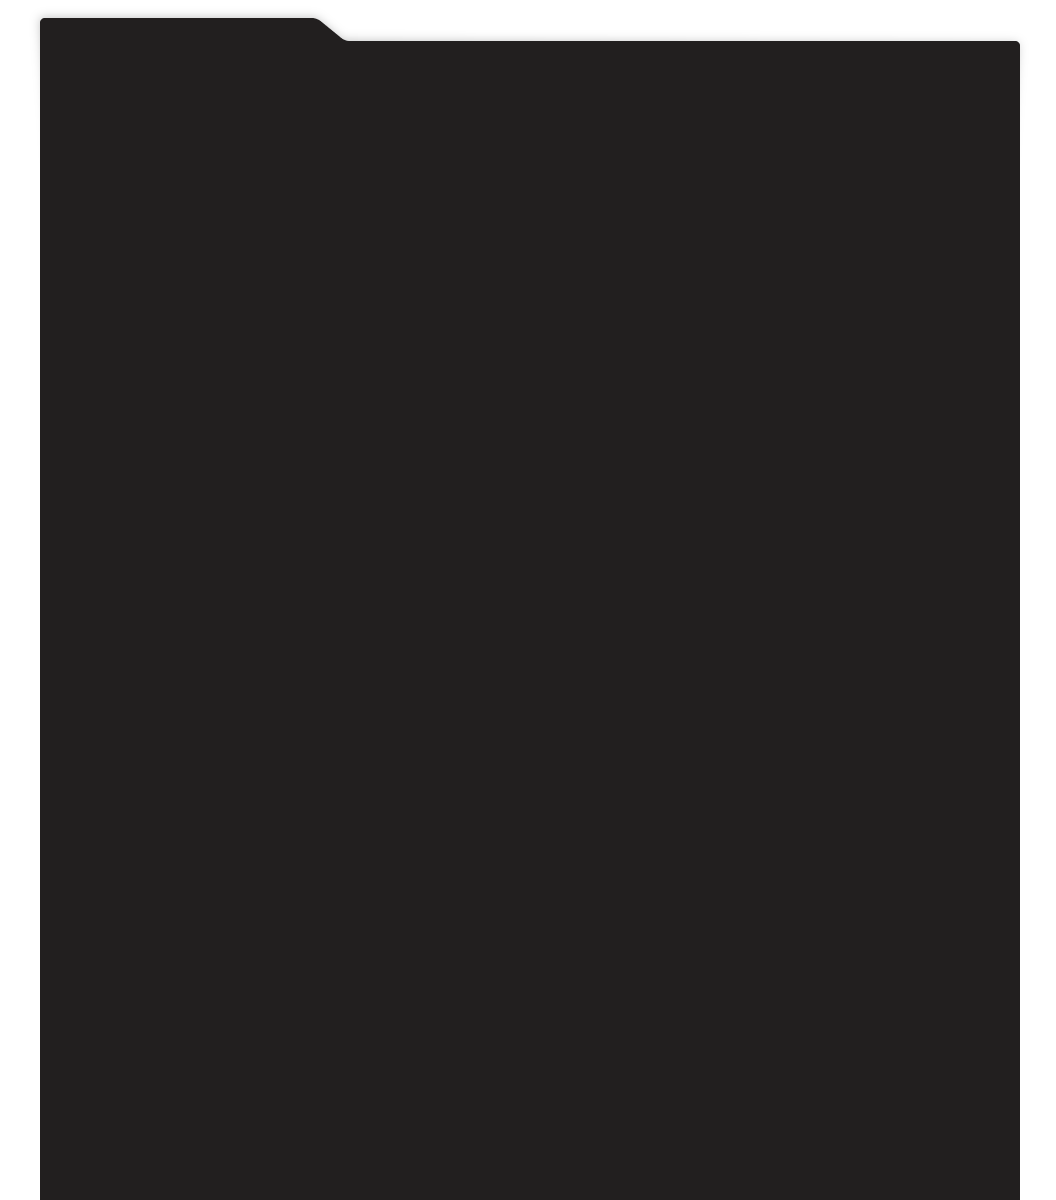
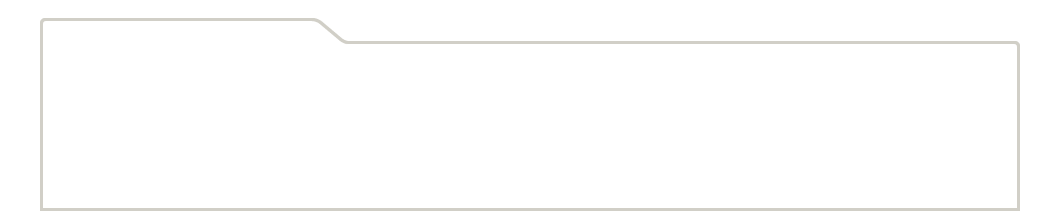
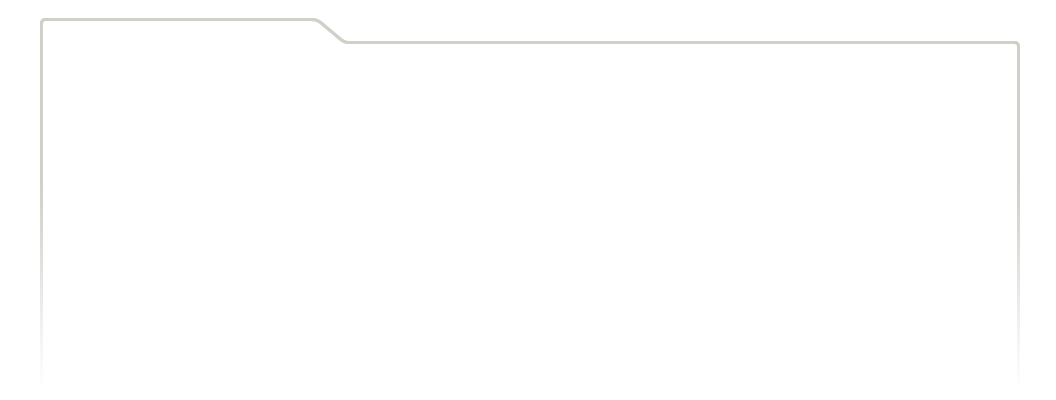
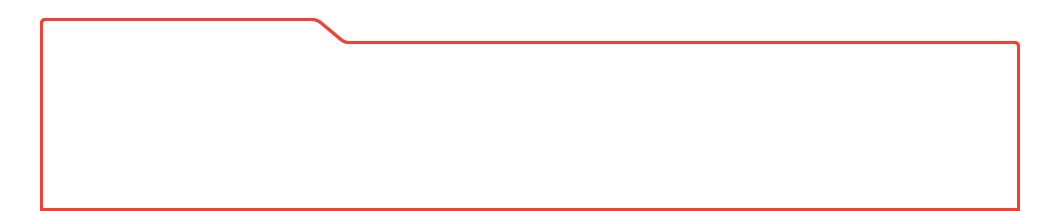
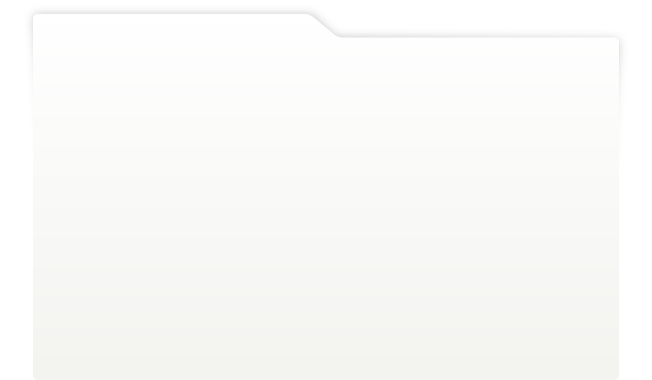
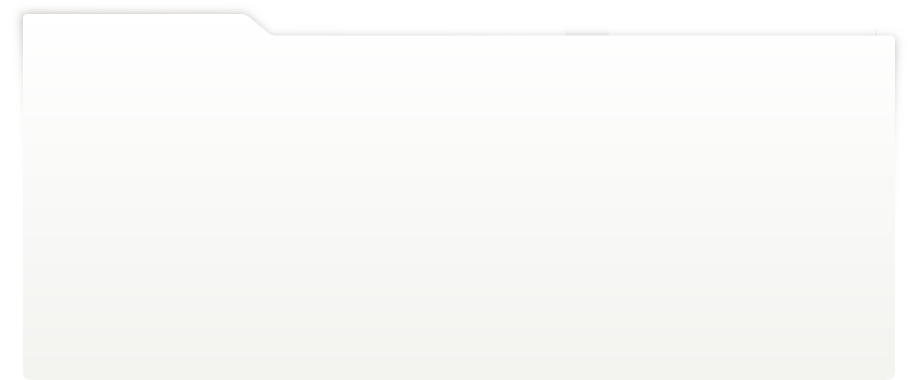
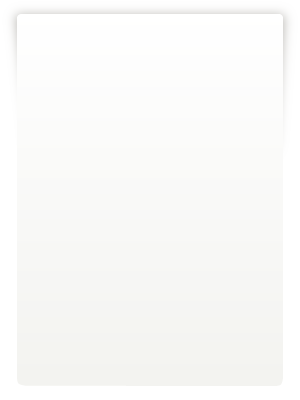
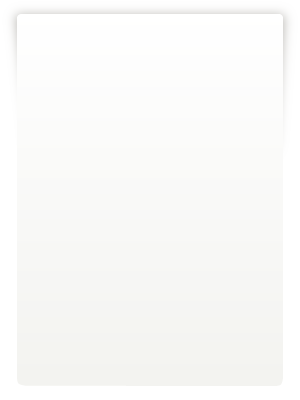
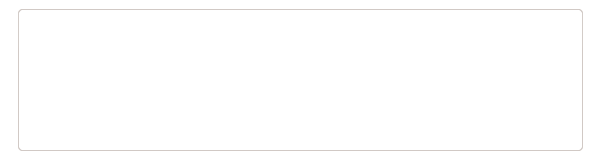
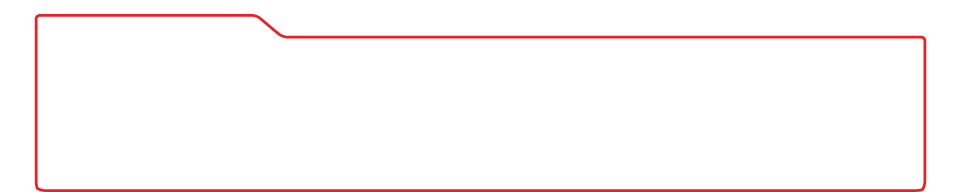
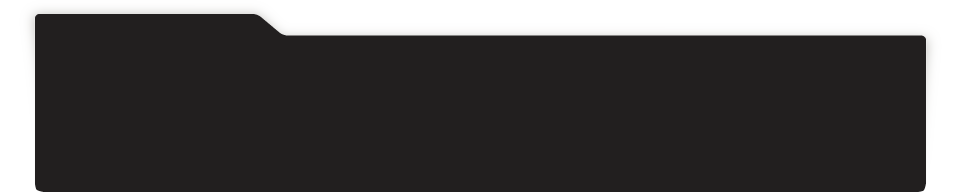
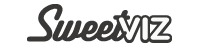
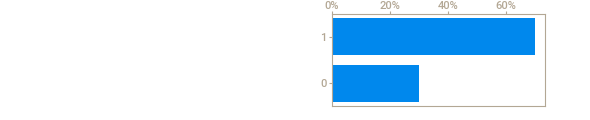
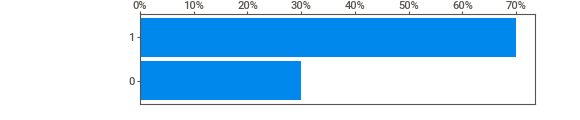
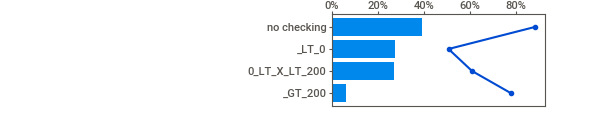
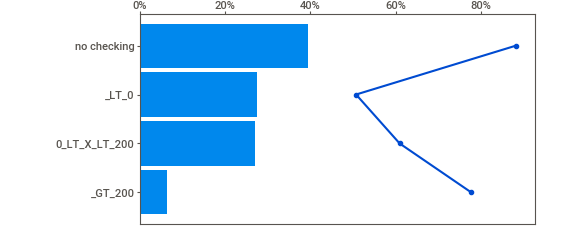
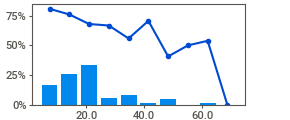
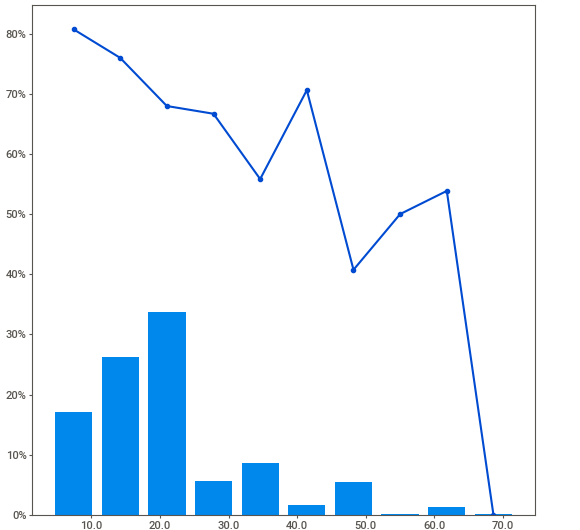
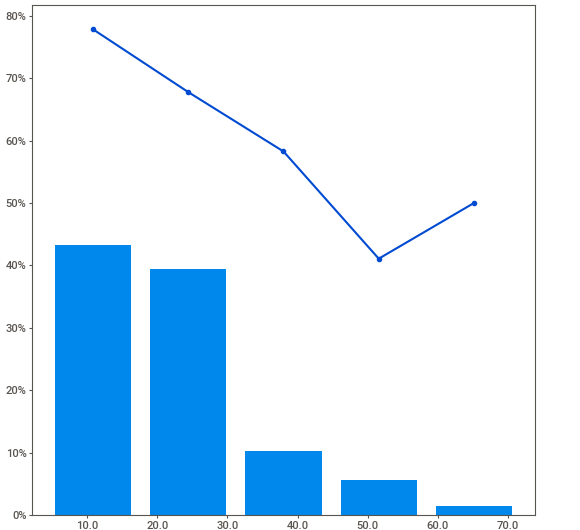
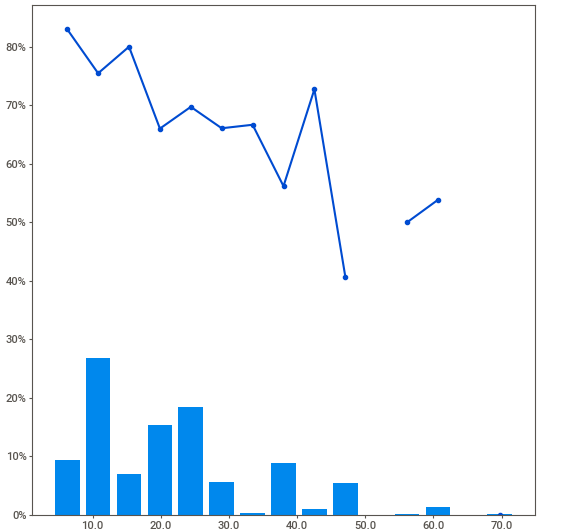
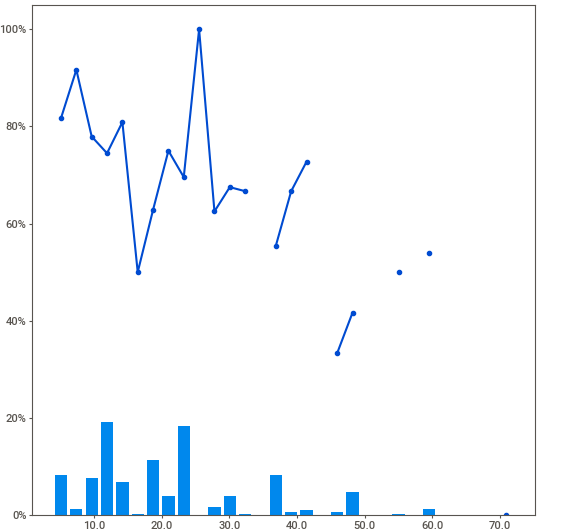
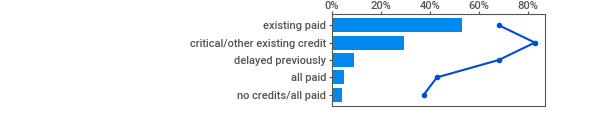
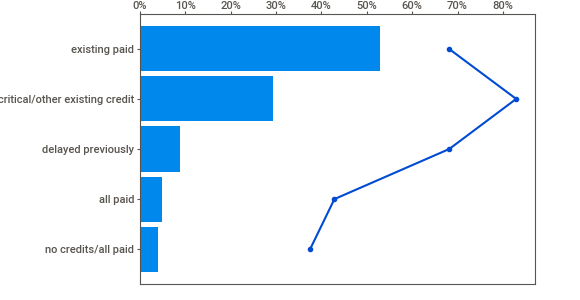
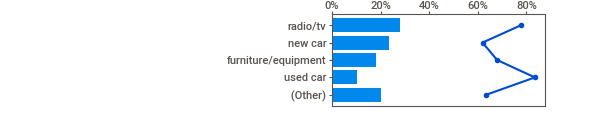
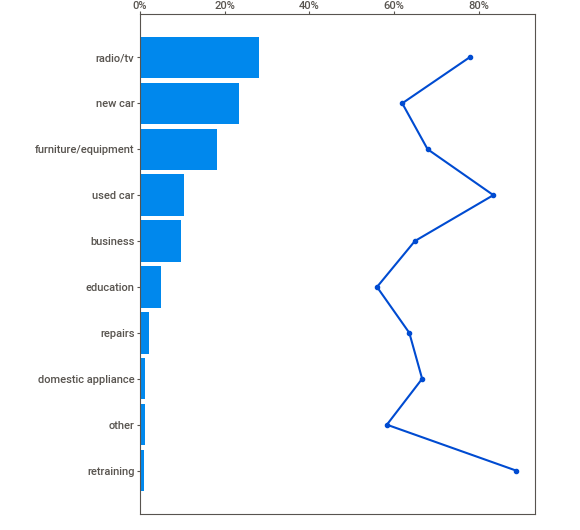
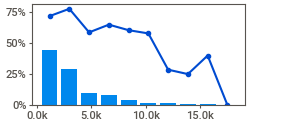
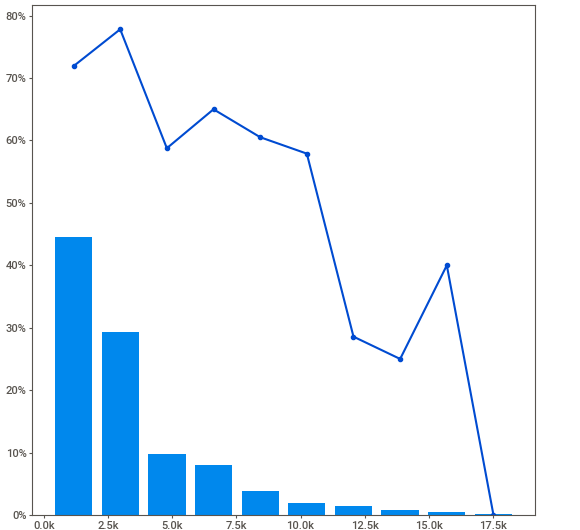
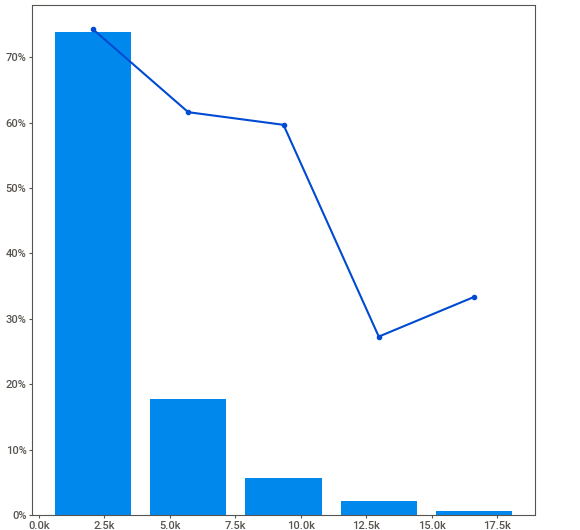
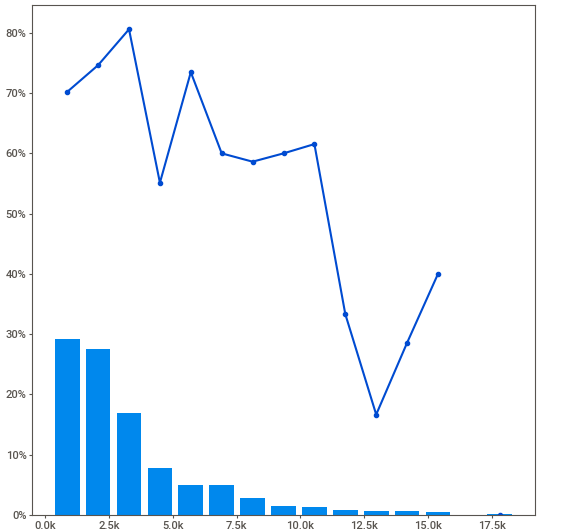
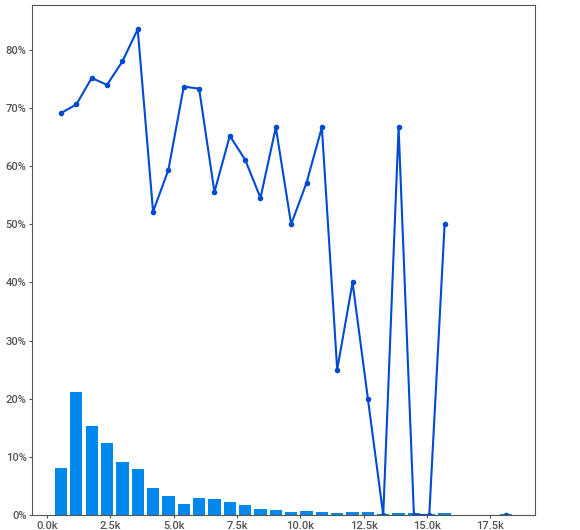
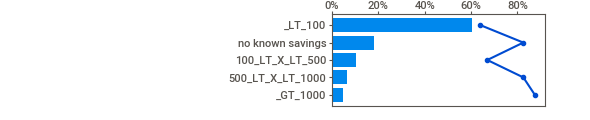
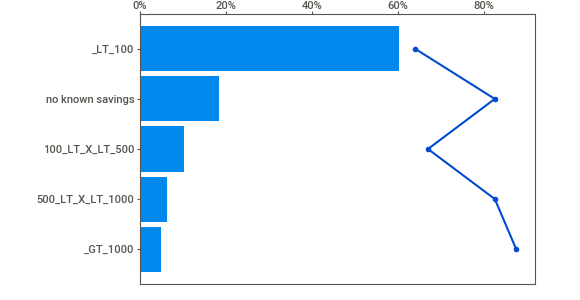
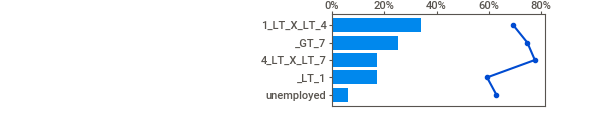
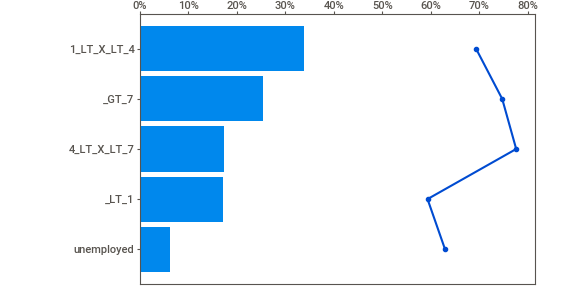
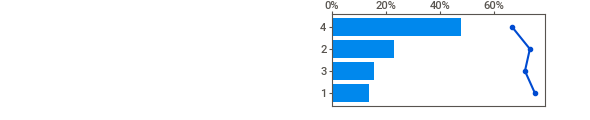
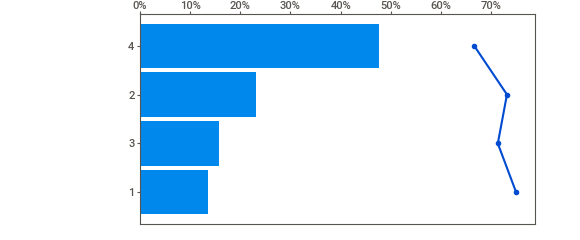
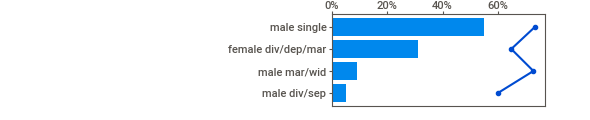
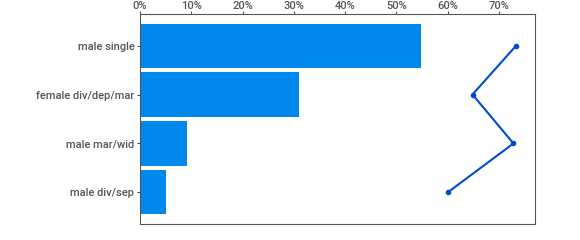
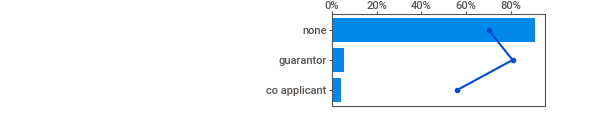
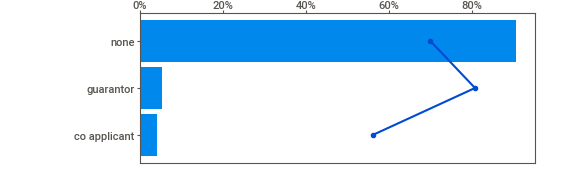
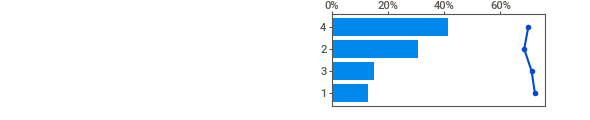
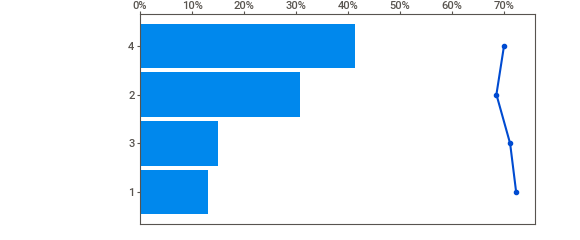
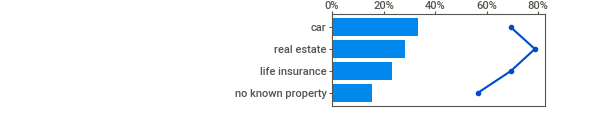
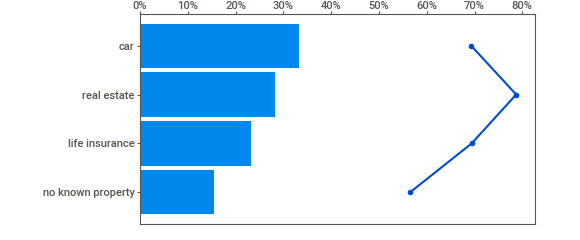
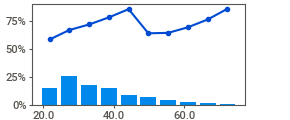
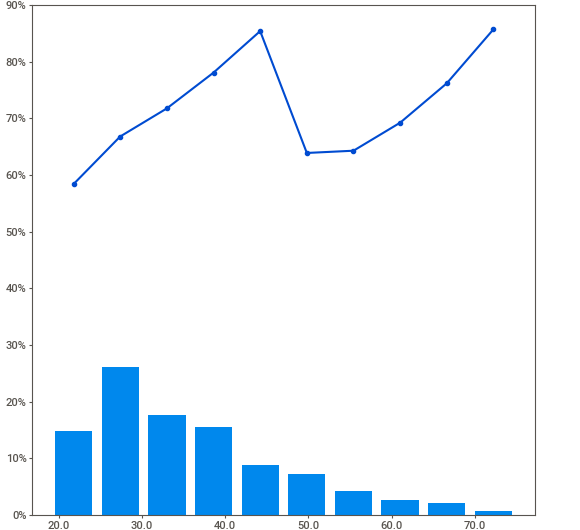
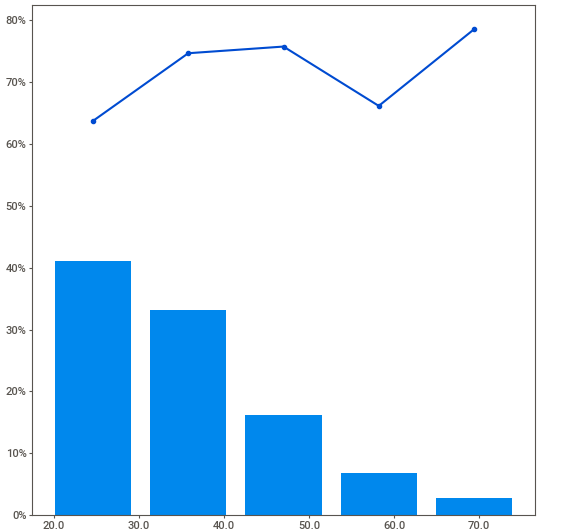
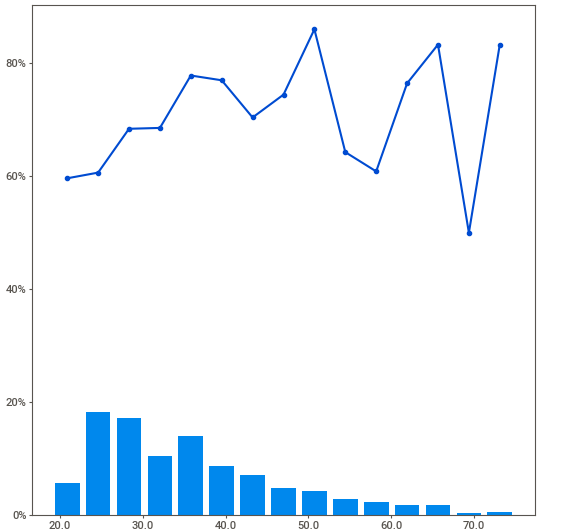
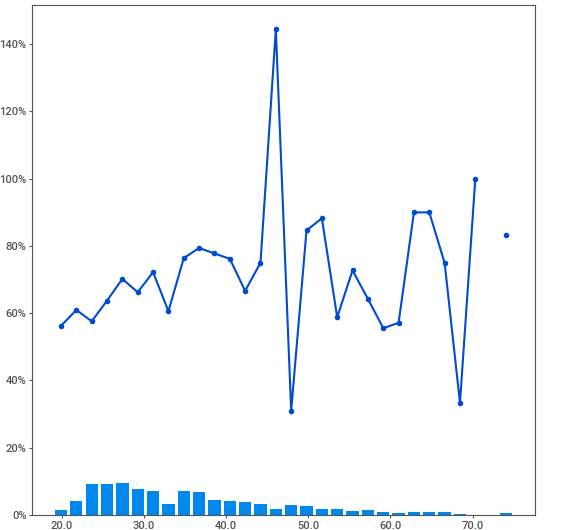
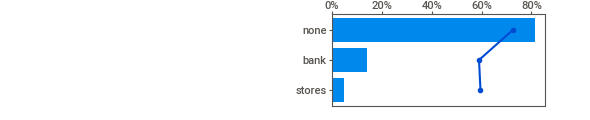
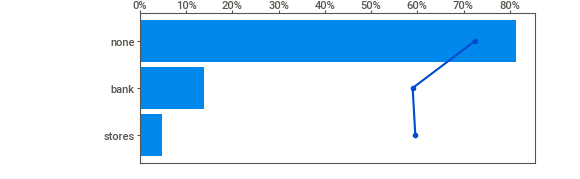
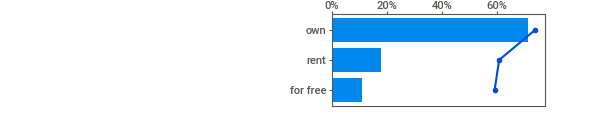
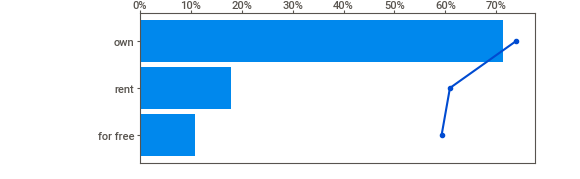
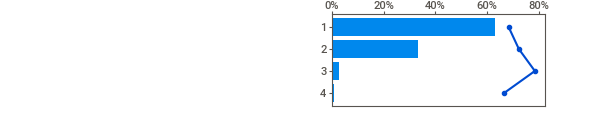
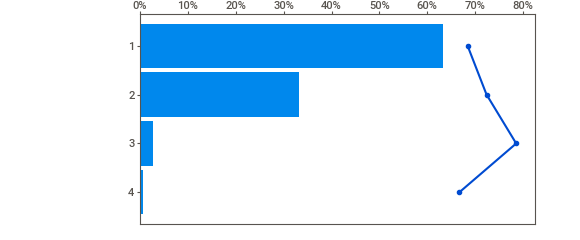
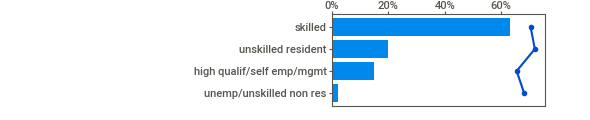
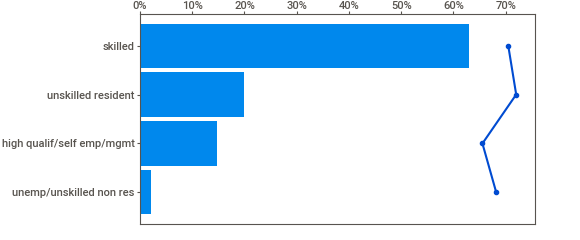
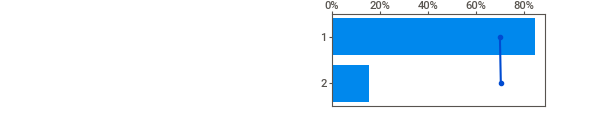
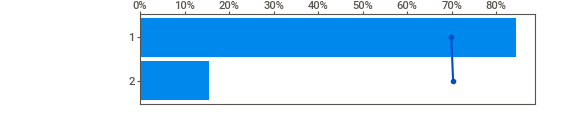
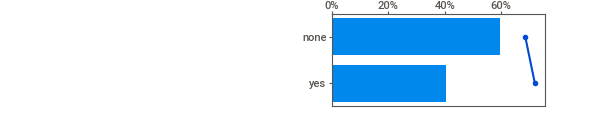
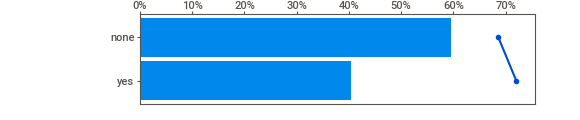
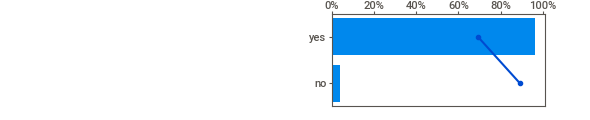
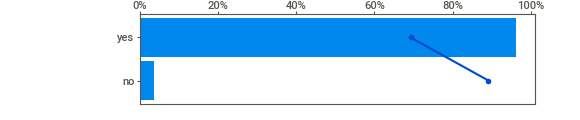
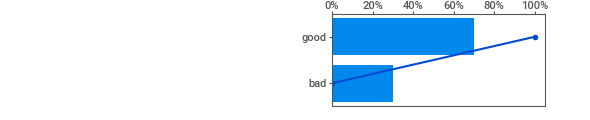
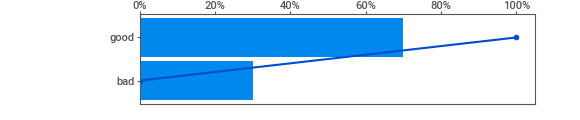
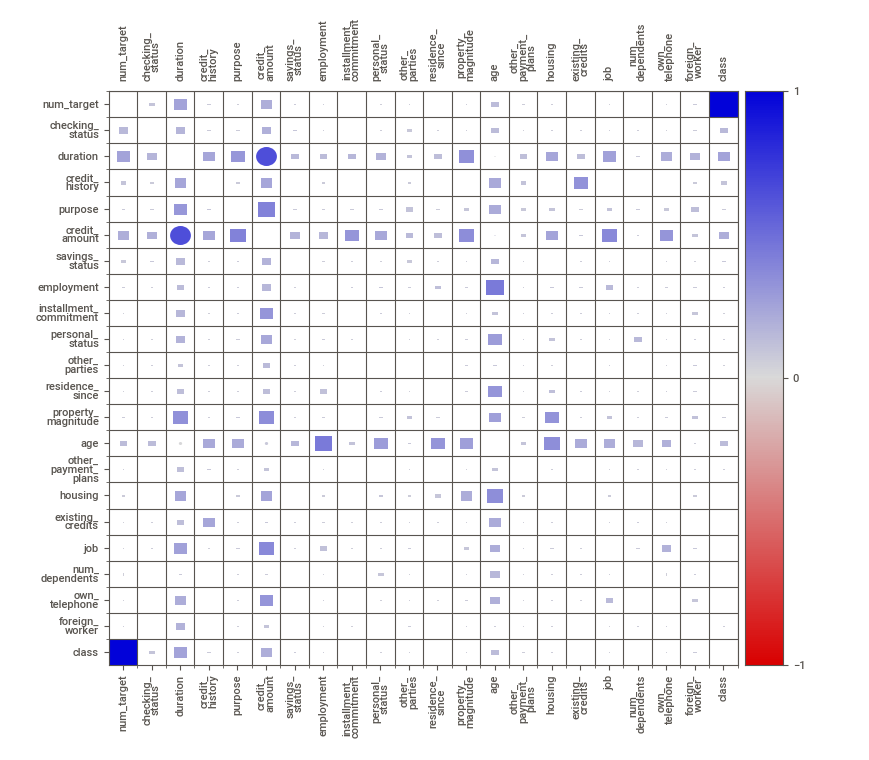
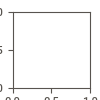

In [ ]:
#### show intercative sweetviz visuals inside notebook
target_analysis.show_notebook( layout='widescreen')

## Things to notice/consider

#### **Target class**
We see a 'good rate' of 70%, i.e. 70% percent of the applicants are classified as good and 30% as bad. This is not a real extreme unbalanced situation, and the balance in this data set is probably already 'artificial' generated by having added more bad loans in the this data set. In real loan portfolios from banks a 30% rate of bad loans would often mean 'end-of-business', you typically would see bad rates of 1 or 2 percent........  

#### **Checking status**  and **saving status**
A large portion of the applicants do not have a checking account. One might consider a separate sub-models for applicants having a checking account and for applicants who do not have a checking account. When the bank that provides the loan also has the loan applicant as a checking account customer, then additional interesting financial info can be derived that will influence the probability of loan repayment. And from the sweetviz visual we do see increasing 'good rates' when here is a higher checking balance.

Same could be said for saving status, the more saving you have the higher the 'good rate'. You need to be awre of potential biasses here. The more balances on savings or checking accounts, the less likely it is you need a loan in the first place.

#### **Duration**

Typically loans would have durations of **12, 24, 36**, etc months (whole years). We do see loans that 'deviate' from these 'whole years' durations. What kind of loans are they? Do they go trough different application process. When an applicant wants a loan of '16 months' is that taylored to a specific situtaion of the applicant? Overall pattern is that the shorter duration of the loan the higher the 'good rate' is

#### **Loan purpose**
A high good rate for 'used cars'. When the applicant gets into financial trouble, the value of used cars are reasable stable (in contrast to new cars) and he/she could sell the car to repay the loan. That may not be the case for other goods, as we see the lower good rates in the visual.

#### **Personal status**
This is a sensitive input variable. It isn't strongly correlated with the target, but you don't want to run the risk of discriminating based on gender. Moreover, it's forbidden to explicitly use such a variable in building credit risk models. Even if this variable isn't used in the model, it could still be biased toward 'personal status'. You shuld do a subpopulation analysis to see if it is, as we demonstrate later in this notebook.

#### **Age**
There is a funy drop in good rate visible at around the age of 50 years. Could this be children related? At that age people who have children might face extra financial spend, school, uni etc? In terms of modeling, this is not a monotone relation, could be an issue in logistic regression for example.

#### **credit history** and **housing**
These two variables can be considered as 'pre selectors of good credits'. Obviously when you have existing credits, you have already undergone the process of credit scoring previously, same for customers that own a house (with a mortgage). Here it would make sense to have additional data for modeling. How long ago was the house bought or the existing loan granted.

### Infrequent category levels
Be aware of input variables with infrequent category levels, but with potentially high (or low) risk!  Two examples here might be 'foreign_worker' and 'other_parties'. We see a small number of applicants which are classed as '*co applicant*', they have a high bad rate. They might not appear or have a large overall impact on the performace KPI's of the final predictive model because of the (very) low occurence. But they could be included as a business rule.

### Missing data

Be prudent when there are missing values! Sometimes the data analists fill in the blanks of missing numerical data with the median or mean value. Or in case when the missing data is categorical, the blank is filled in with the most occuring category level. I think that is a bad thing to do.

1. Find out why the data is missing, and see if missing data can occur when applying the model.
2. Missing value can be a category on its own. I.e. Credit Purpose, missing we could set the category to unknown. 
3. In case of credit scoring, be prudent, don't give *the benefit of the doubt*. Prevent the loan applicant from 'hacking the system' by rather giving no income than a 'bad income'. Or he might not fill in a loan purpose when the money is used for a risky business.....


Often the final scoring system for loan applicants is not just only the predictive models but also a set of 'business rules'. In case of missing info at the loan application, the loan shouldn't pass automatically.

### Correlations and interactions

We see certain correlations between input variables.

**Credit amount** and **duration** are correlated. Obviously, when the credit amount is very high, it is less likely that you can repay that in shorter periods. the higher the credit amount. There is also a correlation between **employment** and **age**, people who are older are more likely to have longer employment history. **Loan purpose** and **loan amount** correlate as well, it's obvious that cars will need more money to buy than TV's.

The correlations aren't really high to be worried about multicollinearity. Nor is it high enough that you would need to drop one of the correlating variables. Looking at the scatterplot below, there is still added value to add credit amount and duration as separate input variables in the model. 

Interactions can be spotted with trees, we are notdiving into this here.


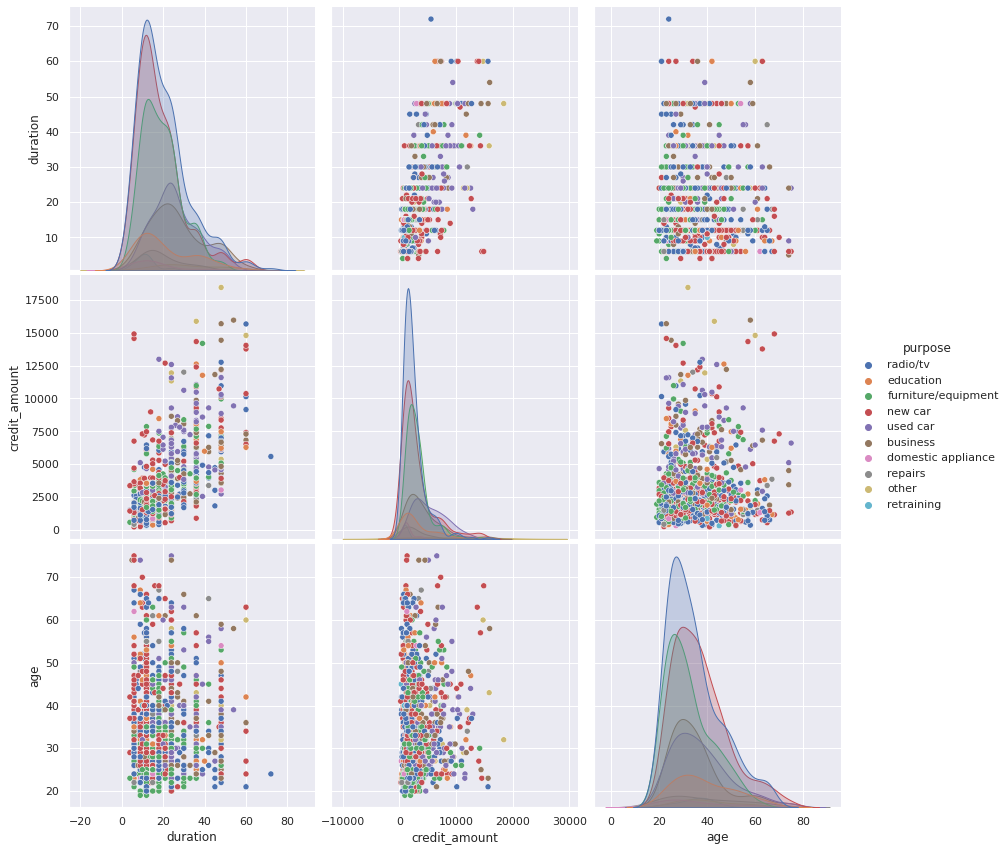

In [ ]:
sns.pairplot(german_credit[['duration', 'credit_amount', 'age', 'purpose']], hue="purpose", size=4)

### Strategy when there are many variables

The German credit data set is a small data set, both in terms of number of variables and number of records. In real life banking loan data, one might have hundreds of potential input variables. In credit scoring, well in any predictive modeling, its very unlikely that you would need all of those hundreds of input variables in the final model.


A first shifting should be done. This can be done with fitting an initial model, say a random forest. Then for this model we could look at the top 20 or 30 impportant variables. If there is enough data, ideally this would be done on a seperate sample of the data, in that case you would not mix variable selecting with model training/testing and validation. Then proceed with the selected variables towards a final model and drop the rest of the variables.



# Predictive Models with Pycaret

In this secion we try different models and chose one model. With Pycaret you need to **setup an 'experiment'** first. We can specify a lot of preprocessing steps with pycaret, such as handling missing data, outliers, correlated variables, and setting cross validation strategies.

For the German Credit data set, the data set is very small, so we do not have the luxury to split the data in many pieces. In general it is good practice to "learn something" from the data (i.e. what variables are important) on a separate part of the data. Thus, preventing 'leakage of information' when using the same data to 'learn' something else (i.e. train the model and get performance and model generalisation KPI's).

In any case, Pycarets default setup will split the data into two parts: a **train** (70%) and a **holdout** (30%). On the train part Pycaret will use cross validation with ten folds to come up with estimates of the model performances like AUC, F1, Kappa, etc. There are many more things you can set, such as how to deal with outliers, correlated variables, missing data etc. We are not going to dive into that here.

We **normalize** the numerical input variables with 'minmax'. Among others, this is important when you want to use variable importance plot in logistic regression. There the (absolute) value of the cofficients are used as importance measures. However, when you have categorical variables which are coded to 0 /1 (by default in PyCaret) then it cofficient estimates will be uncomparable with age or duration, which are more in the scale 0-100.  


The holdout set is used to evaluate the final model.

In [ ]:
### we created an additional numerical target for plotting purposes, so we have two targets in the data set, 
### we need to ignore one target, and also we need to ignore the sensitive input 'personal_status' 
### moreover, we ignore the lengthy default output of the pycaret setup by setting verbose = False

gc_model_setup = setup(
    data = german_credit, 
    target = 'num_target', 
    session_id=123, 
    silent = True,
    verbose = False,
    normalize = True,
    normalize_method = 'minmax',
    ignore_features =  ['class', 'personal_status']
  )  

In [ ]:
### Get an overview of performances for different models.
best_model = compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.7568  0.7623  0.9179  0.7810   
ridge                    Ridge Classifier    0.7454  0.0000  0.8878  0.7846   
lr                    Logistic Regression    0.7439  0.7620  0.8858  0.7842   
rf               Random Forest Classifier    0.7410  0.7481  0.9178  0.7665   
lightgbm  Light Gradient Boosting Machine    0.7382  0.7314  0.8758  0.7841   
lda          Linear Discriminant Analysis    0.7368  0.7579  0.8578  0.7917   
et                 Extra Trees Classifier    0.7353  0.7128  0.8858  0.7761   
ada                  Ada Boost Classifier    0.7311  0.7282  0.8598  0.7842   
gbc          Gradient Boosting Classifier    0.7311  0.7379  0.8838  0.7725   
xgboost         Extreme Gradient Boosting    0.7225  0.7108  0.8577  0.7784   
dummy                    Dummy Classifier    0.7139  0.5000  1.0000  0.7139   
svm                   SVM - Linear Kernel    0.7067  0.0000  0.8899  0.7574   
knn                K Neighbors Classifier    0.7009  0.6421  0.8756  0.7481   
dt               Decision Tree Classifier    0.6525  0.5978  0.7256  0.7727   
qda       Quadratic Discriminant Analysis    0.6195  0.5105  0.7659  0.7218   
nb                            Naive Bayes    0.4177  0.7122  0.2184  0.8543   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.8436  0.3115  0.3336     2.354  
ridge     0.8327  0.3070  0.3187     0.017  
lr        0.8316  0.3043  0.3159     0.452  
rf        0.8351  0.2528  0.2751     0.524  
lightgbm  0.8270  0.2946  0.3029     0.154  
lda       0.8232  0.3112  0.3159     0.027  
et        0.8269  0.2735  0.2862     0.519  
ada       0.8199  0.2921  0.2996     0.135  
gbc       0.8243  0.2618  0.2738     0.191  
xgboost   0.8149  0.2605  0.2698     4.431  
dummy     0.8331  0.0000  0.0000     0.017  
svm       0.8075  0.1439  0.1768     0.027  
knn       0.8063  0.1626  0.1794     0.121  
dt        0.7479  0.1897  0.1909     0.020  
qda       0.7380  0.0163  0.0105     0.022  
nb        0.3420  0.0872  0.1521     0.017

**Note** The model performance KPI's without the sensitive 'personal_status' are only slightly worse than the model with the sensitive input variable.

## Modeling considerations

The table above shows different performances for different models. It is a first indication what type of models perform bad, better or good on this specific data set. The performance KPI's above will only partiallly help you in your final model choice.

**Keep in mind** that we have a very small data set here at hand, and as we see below the performance measures vary quit a lot from fold to fold. So, in this case, do not blindly stare on a model whose performance is slightly better in the table above.

### Keep it simple (Ockhams Razor)

I always use the Ockhams Razor principle. Logistic regression (lr) is one of the simplest machine learning models: it's easy to interpret, it doesn't have a lot of hyperparamters to tune and is computationally 'inexpensive' compared to other algorithms.

When we look at the performances we see that lr is performing not too bad, compared to the more fancy tree based methods.

Why is lr already so good? We've got some input variables with not that many categories, lr can capture those differences pretty well. It takes only one parameter to model the relation between duration and the target, tree based methods need more steps to estimate this relation from the data.

### Reasons why lr performs less than other (tree based) methods

There might be different reasons why lr would perform (much) less than other (tree based) methods

1. When a numerical input variable shows a non linear relation with the target, lr can not capture this effect (without applying some tricks). 

2. Interactions might be present in the data. Suppose the relation between duration and the 'good/bad' target is much different for 'car loans' than it is for 'TV-loans', then a lr has a hard time to capture this effect, while with trees, this effect can be captured almost automatuically by nature of the algorithm.

### Discreteness of Tree based methods

Be aware of the discreteness of tree based methods. This might be especially an issue in such small sets as this one. Numerical input variables are essentially cut into intervals. Suppose income is a driver in the model, an applicants income could just be 1 Euro short of a split and therefore fall in another branch of the tree....

### Applying the model

Other considerations in choosing a model might be the way you need to deploy the model. Complex models might be hard(er) to deploy, especially when you have to deal with legacy systems. Although now with pycaret you can spinup a FASTAPI and encapsulate it from any of the models that you created, even complex ensembles.





# Focus on logistic regression model

With pycaret you can now focus on a specific model. You can either fine tune and optimize for hyper parameters. Moreover, take a deeper understanding in the performance and explainability of the model.

We are going to dive a bit deeper into the logistic regression model, because this is a model that works pretty well already on this data set.

In [ ]:
### First isolate the model into an object (it is just a Scikit learn logisticRegtession object)
### You get to see the different performance KPI's on the ten CV folds.

GC_lrm = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7571  0.7950  0.9200  0.7797  0.8440  0.3121  0.3352
1       0.7429  0.7170  0.9000  0.7759  0.8333  0.2841  0.2997
2       0.8000  0.7490  0.9400  0.8103  0.8704  0.4432  0.4675
3       0.7143  0.7200  0.8800  0.7586  0.8148  0.2045  0.2158
4       0.8000  0.8410  0.9000  0.8333  0.8654  0.4787  0.4841
5       0.7429  0.7710  0.8800  0.7857  0.8302  0.3077  0.3162
6       0.7000  0.7500  0.8600  0.7544  0.8037  0.1788  0.1859
7       0.7429  0.7610  0.8400  0.8077  0.8235  0.3505  0.3514
8       0.7143  0.7290  0.8400  0.7778  0.8077  0.2553  0.2582
9       0.7246  0.7867  0.8980  0.7586  0.8224  0.2284  0.2453
Mean    0.7439  0.7620  0.8858  0.7842  0.8316  0.3043  0.3159
SD      0.0324  0.0364  0.0310  0.0245  0.0214  0.0928  0.0940

### Feature importance

The plot below shows the feature importance plot, of all variables. It is a long list. We see Duration and credit amount as important variables. You typically would see a tail of variables that are less important to almost not important. If you want to remove some redundancy from the model without sacrificing on performnce too much, you might consider to remove some of the input variables that are 'not important'. 

Be aware of **'foreign worker no'**, as we noted before, only a small fraction of applicants has this value. We cross check the importance by comparing with the feature importance of a random forest model. The feature importance of tree based methiods are detrmined in complete different way.

The plot below using a random forest shows that **foreign worker** was almost not important in that model.

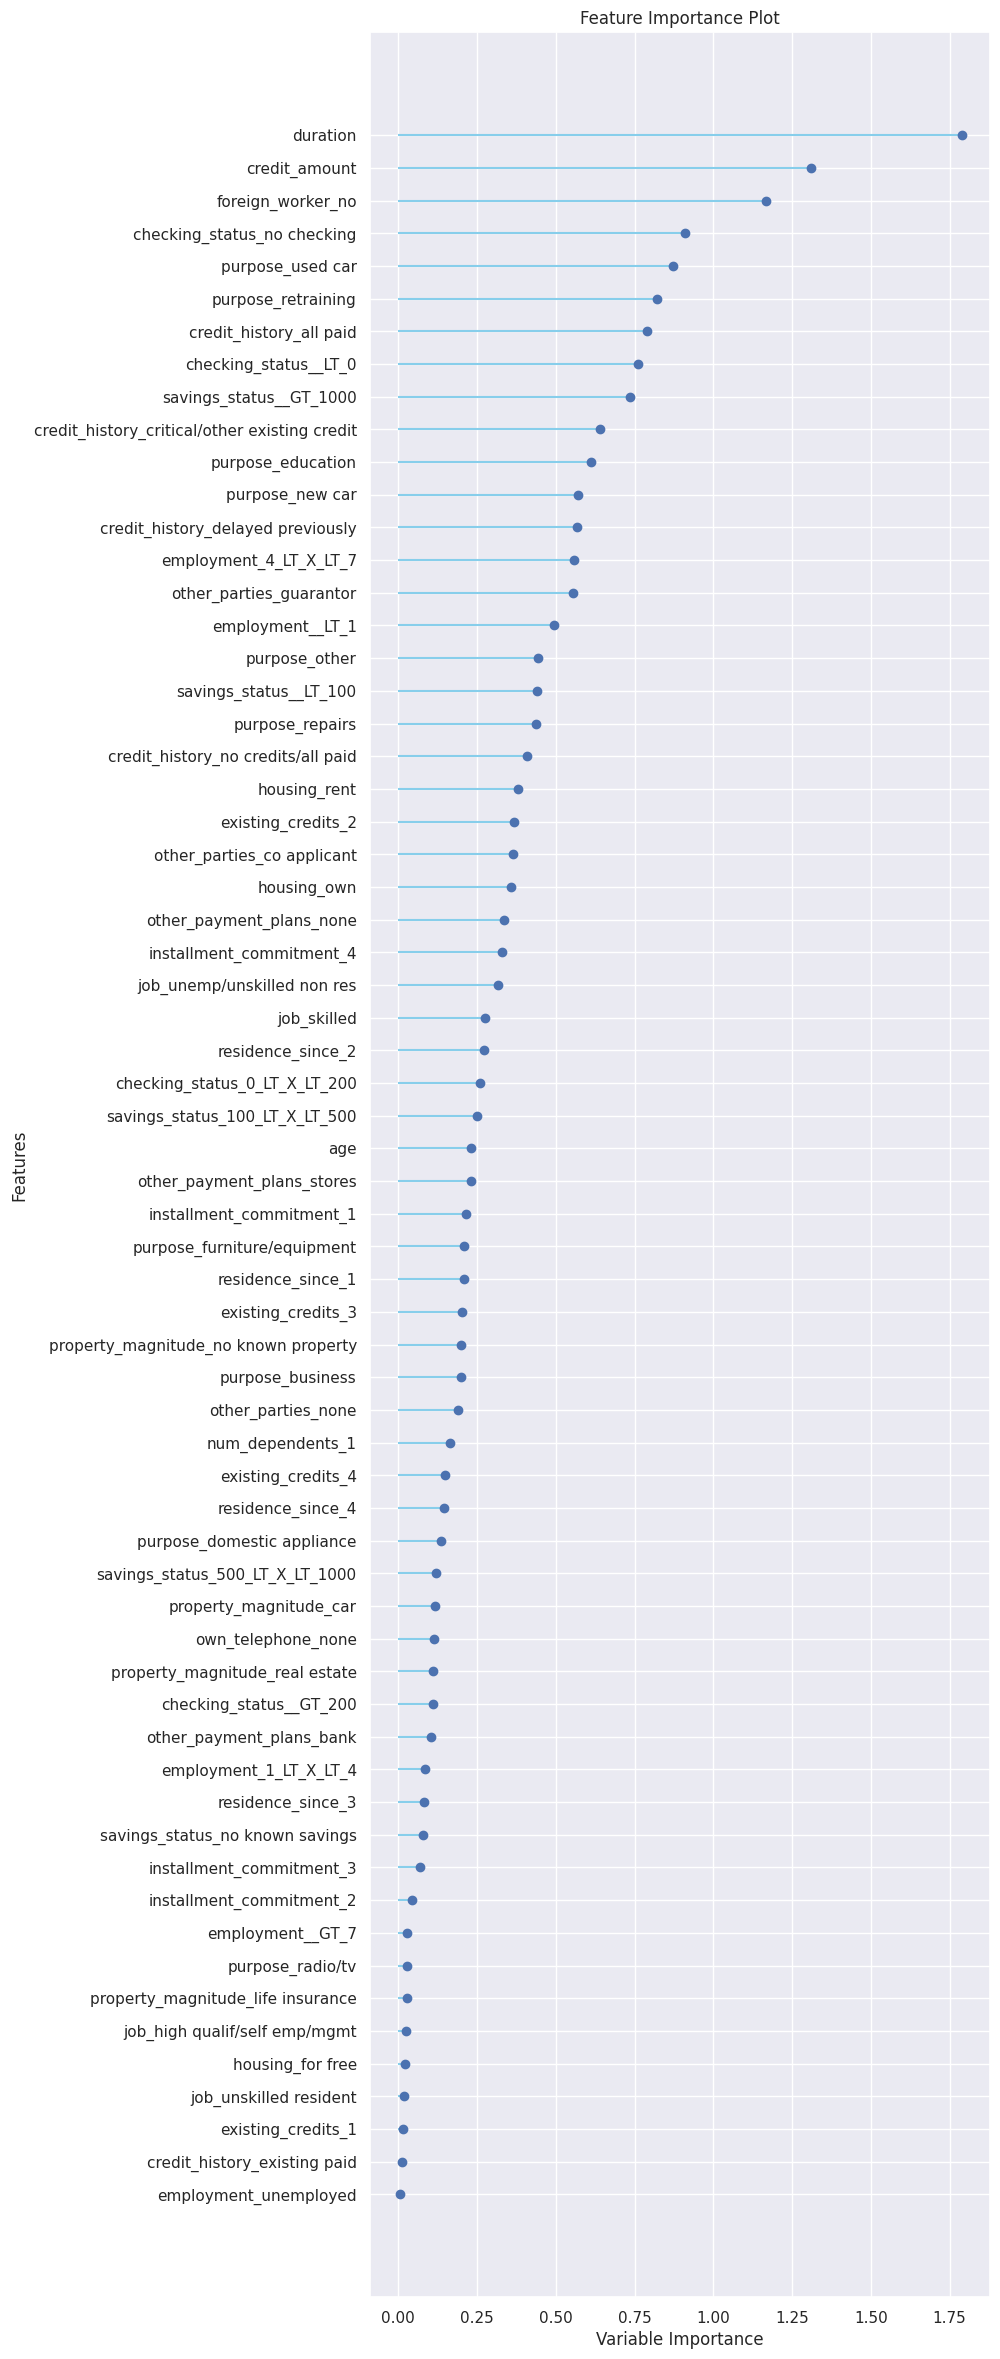

In [ ]:
plot_model(GC_lrm, plot = 'feature_all')

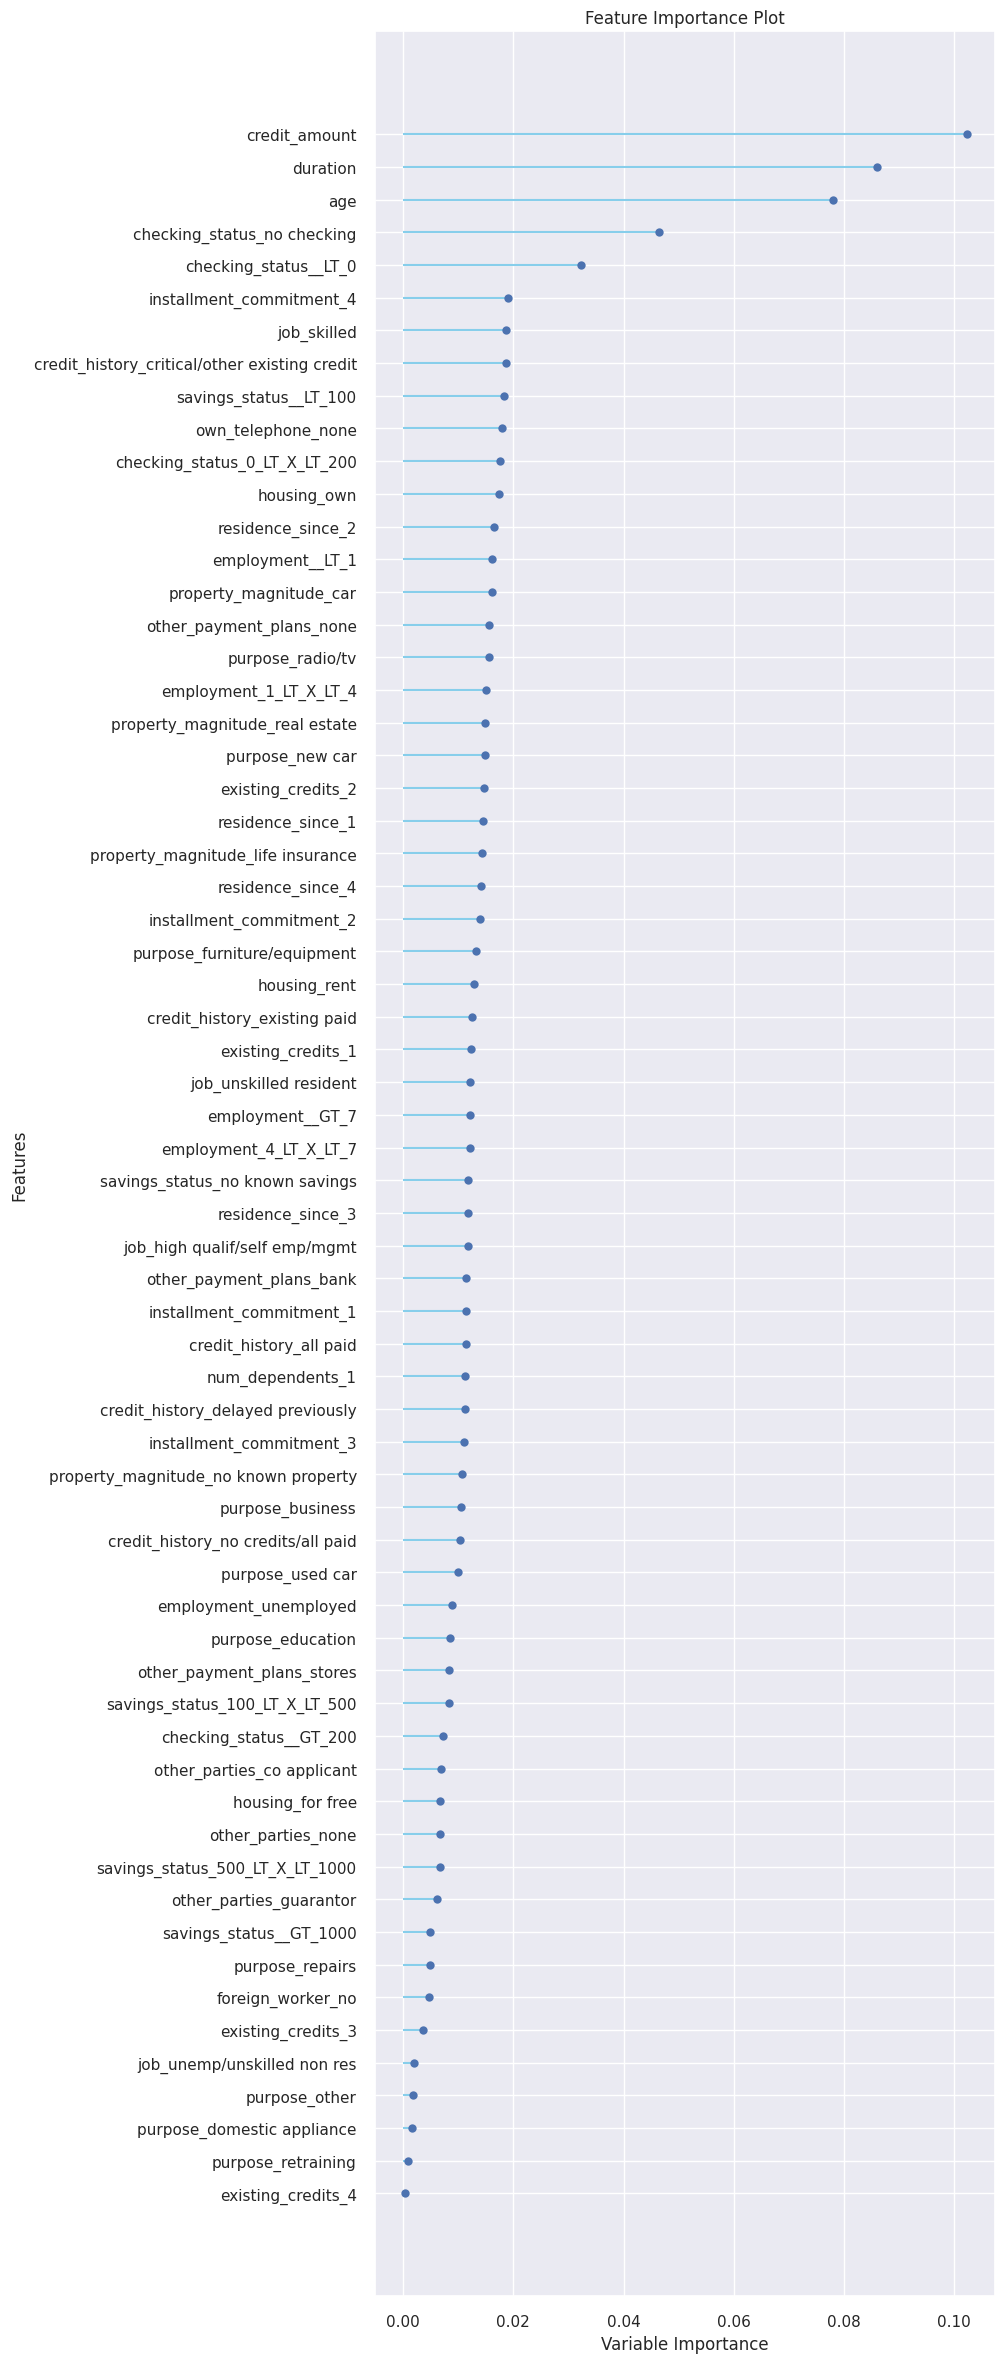

In [ ]:
GC_rf = create_model('rf')
plot_model(GC_rf, plot = 'feature_all')

### Model Performance

We have seen performance KPI's of the logistic regression already in numerical form. It is good practice to dive into a couple performance metrics deeper, by means of graphical inspection.

#### ROC curves

A ROC curve plots the false positive rates against the true positive rates at different tresholds. It gives a good overview on how much better the machine learning model is compared to a useless model (say by taking the last digit of the account number of a loan applicant and predinf good if it is a seven or higher). In that case the roc curve would be very close to the diagonal line.

The curve starts at the left lower corner, ideally then the curve would go steeply to a point near the left upper corner and then to the right upper corner. That is not the case here, the model is not perferct. 

Another feature to look for is that the curve is as 'convex' as possible. We see that the curve 'collapses' a little bit in the lower part. We do not have a lot of data here so the score might not be as smooth as we would have liked. It might also indicate that the logistic regression model has not captured certain relations very well. See the roc curve of the catboost model as a comparison, which does not show this 'collapsing' behaviour and the curve is more convex.

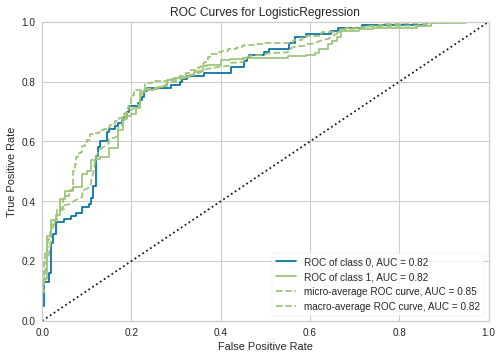

In [ ]:
plot_model(GC_lrm, plot = 'auc')

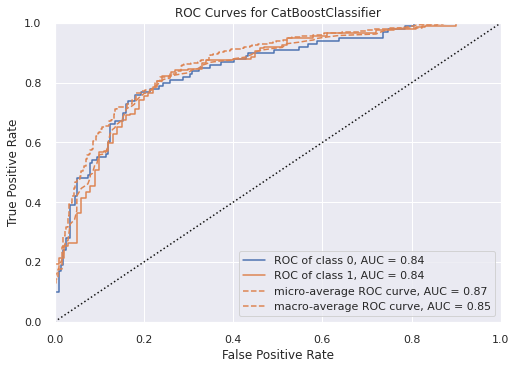

In [ ]:
GC_catb = create_model('catboost')
plot_model(GC_catb, plot ='auc')

#### Kolmogorov-Smirnov curves

When all the applicants in the holdout set are scored using the logistic regression model, you hope that the 'bad cases' and the 'good cases' have different scores. The model scores of those two groups should be as far apart if the model has any predictive power.

One way to measure 'how far apart' scores are, is the so called **Kolmogorov-Smirnov** statistic. The plot below shows the two score distributions of the good and bad cases in the holdout set. They curves are seprated, the model does a reasonably well job in seprating the classses. 

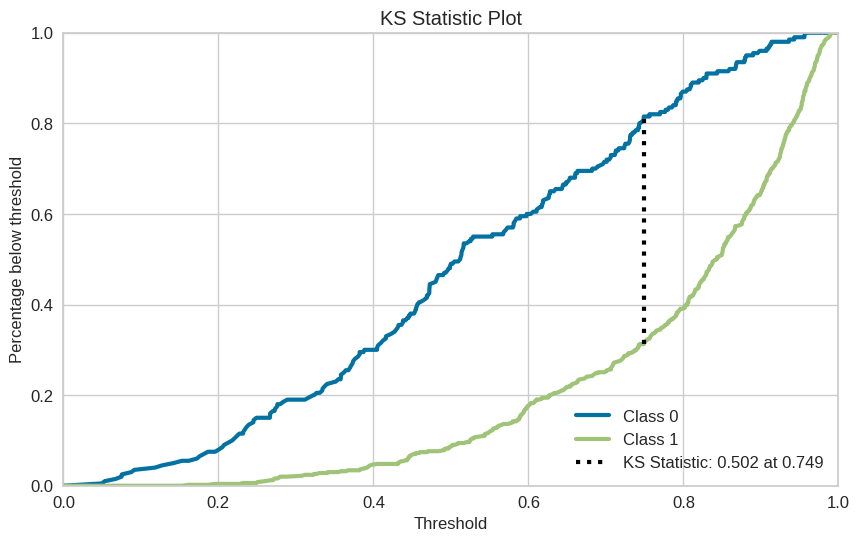

In [ ]:
plot_model(GC_lrm, plot = 'ks')

#### Lift curves

The two graphs above are rather technical by nature and are more tools for the data scientist to judge the quality of the model. Lift curves on the other hand are an easier tool to show to the people from the business. 

The holdout set is once again scored by the logistic regression nmodel. The cases are then sorted by score, it is common then to divide the scored cases into ten equal buckets ranging from a high score to low score.

If the model is good, then in the best bucket you would expect a lot of bad cases. And what is a lot? Well, you can count the number of bad cases in the bucket and compare that to the overall bad rate, when you know nothing. There is a bad rate of 30% in this data set. What you see in the cruve below is a lift of 3. That means the bad rate in that bucket is around 90%.

The curve here is eratic, due to the low number of records in the holdout set.

But now this curve can be used to set a cut off treshold for which you are going to reject new loan applicants or not. Setting a low treshold will mean that you are accepting buckets with high bad rates and low good rates. This can still be profitable, depending on how much money is made on the good loans.

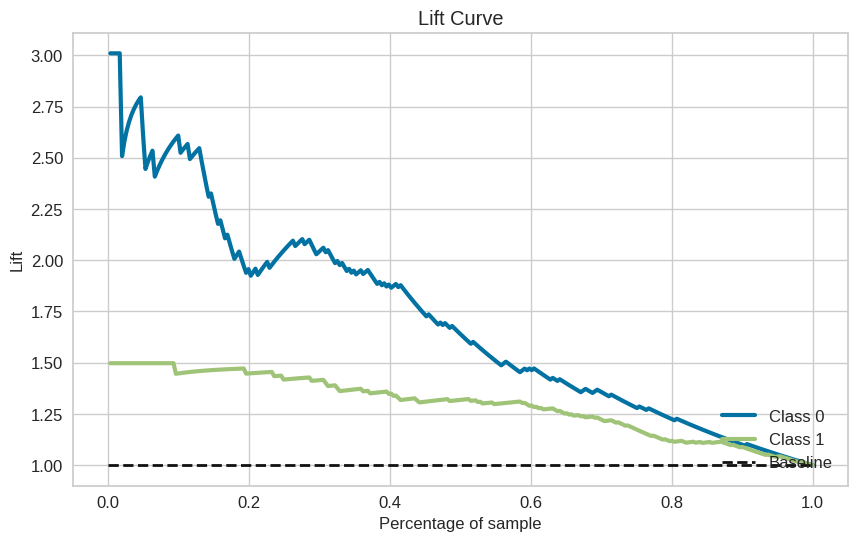

In [ ]:
plot_model(GC_lrm, plot = 'lift')

## Model explainability

Model explainability comes automatically when using logistic regression. The whole model is completely goverened by only the set of coefficients  that are determined during the training of the model. We first get the names of the input features. **Note** that these are different from the column names in the german credit data set. Pycaret has taken care of creating dummy variables for categorical variables by using one-hot encoding and thus creating additional 'features'.

Then we extract the set of coefficients from the logistic regression model object. and put it in a frame for presentation purposes. Now the score of a logistic regression is linear additive in the log odds. If we are not bothered with the predicted probability, just a score from which we can see if one loan applicant is better than another loan applicant, then we can just multiply the cofficients with a factor and add a constant to the score.

This will make them easier to interpret, we can get rid of the intercept and make them mostly positive and scale them so they look pretty. See table below.

In [ ]:
model_presentation = pd.DataFrame({
    'input_name' :  get_config(variable="X_train").columns,
    'coefficient':  GC_lrm.coef_[0,:]
})

model_presentation['score_points'] = np.round(model_presentation['coefficient'] * 1000 + 800,0)
with pd.option_context("display.max_rows", 1000):
    display(
        model_presentation
        .style.background_gradient(cmap ='RdYlGn')
        .set_properties(**{'font-size': '12px'})
    )


It is now easier to compare the different points, Within an input variable or between input variables
 
For example checking status, the impact of having zero balance on your checking account versus more than 200 on your checking account.

## Explainability for more complex models

The explainability of the logistic regression model as showed above is not that simple for other more complex models. 

First of all, the relation between the score predictions and the input drivers might be complex nonlinear relations. In logistic regression this was assumed to be linear. We can see the relations with **partial dependence plot**.

Second, to explain why a score is given and what input variables attributed to that score (and how much) will now in generaly depend on the input valies themselves. We can use so-called **SHAP values**. 

The figures below will address these issues, when one tries to explain a more complex model. Let's see them in action for our German credit data set, where we are explaining a catboost model.

In [ ]:
GC_catb = create_model('catboost')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7714  0.7750  0.9400  0.7833  0.8545  0.3412  0.3744
1       0.7429  0.7110  0.9000  0.7759  0.8333  0.2841  0.2997
2       0.8286  0.7600  0.9800  0.8167  0.8909  0.5059  0.5551
3       0.7143  0.7530  0.9000  0.7500  0.8182  0.1765  0.1936
4       0.8429  0.8630  0.9400  0.8545  0.8952  0.5838  0.5945
5       0.7429  0.7780  0.8800  0.7857  0.8302  0.3077  0.3162
6       0.7143  0.7360  0.9200  0.7419  0.8214  0.1463  0.1704
7       0.7143  0.7010  0.9000  0.7500  0.8182  0.1765  0.1936
8       0.7429  0.7470  0.8800  0.7857  0.8302  0.3077  0.3162
9       0.7536  0.7990  0.9388  0.7667  0.8440  0.2852  0.3217
Mean    0.7568  0.7623  0.9179  0.7810  0.8436  0.3115  0.3336
SD      0.0433  0.0439  0.0302  0.0323  0.0270  0.1334  0.1366

#### partial dependence plot

A partial dependence plot shows the effect that an input variable has on the predicted score. Take for example duration, in the LR model we just had one coefficient for duration. The model asssumed a linear relation.

Now, it depends on the value of duration what effect the duration has on the credit score outcome. We see here longer duration have little effect on the outcome than shorter durtions. 

In [ ]:
interpret_model(GC_catb, plot = 'pdp', feature = 'duration') 

#### SHAP values

These are values that will tell how each of the individual values of a specific loan applicant has contributed to the final score. The first plot shows tha SHAP values of observation 0 of the holdout set.

The second plot shows all the observations. Each dot is a loan applicant in the holdout set. points right from the vertical line increase the "probability of good". This is a convenient plot, it combines individual explanations with over variable importance.

In [ ]:
interpret_model(GC_catb, plot='reason', observation=0)

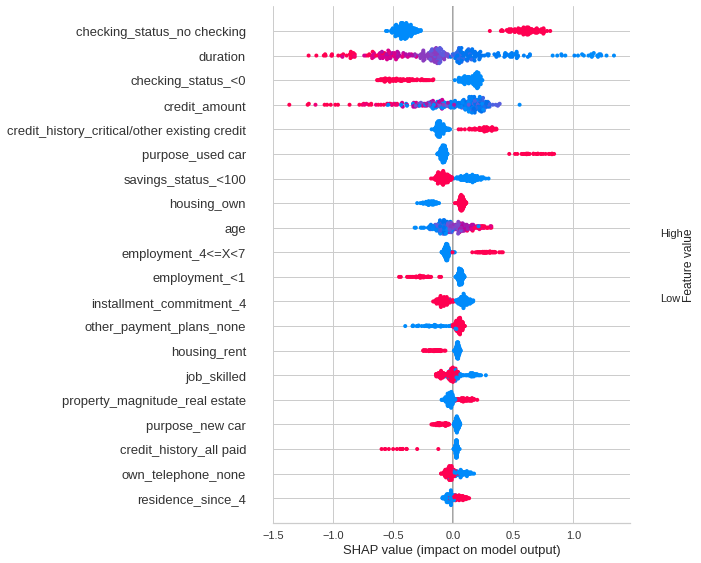

In [ ]:
interpret_model(GC_catb)

## AI Fairness

There are different apporaches to AI faireness, however, one important question you should ask as a creator of machine learning model is this: are there groups of individuals (in terms of 'sensitive' variables such as  race, gender) for which your model is biased. I.e. in the case of credit scoring, are there groups of individuals who are less likely to receive a good score from the model.

Ideally we would like to have:

P(accept credit | input = X and gender = Male) = P(accept credit | input = X and gender = Female)

We did not use 'personal status' as a driver in the model. However, your model could still be biased towards 'personal status' because of other input variables that is related toward 'personal status'.

We apply the predictive model on the holdout set and see if perforamnce measures differ (strongly) on the individual categories. If there is no biass then these measures would be the roughly the same.



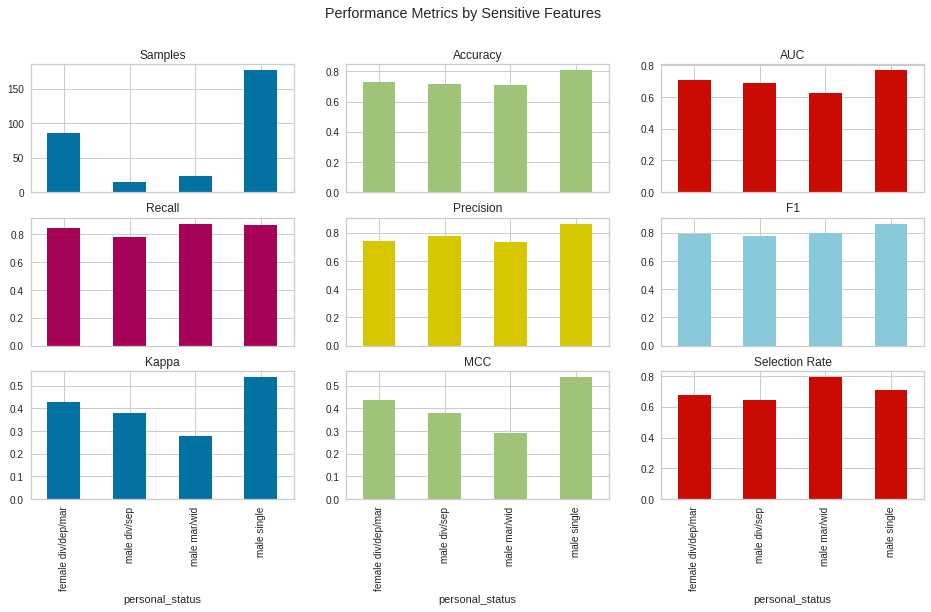

In [ ]:
lr_fairness = check_fairness(GC_lrm, sensitive_features = ['personal_status'])

In [ ]:
lr_fairness

Samples  Accuracy  ...       MCC Selection Rate
personal_status                       ...                         
female div/dep/mar      86  0.732558  ...   0.43463       0.674419
male div/sep            14  0.714286  ...  0.377778       0.642857
male mar/wid            24  0.708333  ...  0.290191       0.791667
male single            177   0.80791  ...  0.537077       0.706215

[4 rows x 9 columns]

The samples are small here, so it is hard to say anything conclusive here. But looking the 'selection rate' (i.e the fraction of predicted labels matching a good outcome) we see the model biased towards a high "male maried widow" compared to "female div/dep/mar".

# Conclusion

Obviously the data set here at hand is only a very small sub sample of the data that banks typically would have on loan applicants. It's a rather old data set, i.e. telephone variable, that wouldn't be used nowadays. 

Some of the input variables are already classed into buckets. Take for example 'checking status'. Maybe the different categories of 'cehcking status' was already done by the business, a credit officer with domain knowledge. Nowadays, when you would have the information the current account, you as a data scientist can derive many more features from the historic transactions of the current/checking account.


Altough there are some serious limitations on this data set, it can still be used to demonstrate the typical steps one needs to take to create a credit scoring model and assess if the model is appropiate to use.



